---
title: Random Number Generators
author: Your name
date: Today's date
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.stats import norm

# Testing Randomness of Linear Congruential Generators

In this notebook, we will test the quality of a Linear Congruential Generator (LCG) using a few of the tests from the NIST Statistical Test Suite. The tests we will use are:

1. Chi-Square Test
2. MonoBit Frequency Test
3. Runs Test

We'll start by defining the LCG. Throughout this notebook we'll fix $m = 2^{12}$ and $c = 1$.

In [2]:
# import scipy.stats as stats

# # Find the 95th percentile of the chi-square distribution with 1 degree of freedom
# chi_squared_critical_value = stats.chi2.ppf(0.95, df=1)

# print(chi_squared_critical_value)


In [3]:
# class for PRNG
class PRNG:
    def __init__(self, seed, m):
        self.value = seed
        self.m = m

    def __next__(self):
        # to be implemented in subclass
        raise NotImplementedError
    
    # generate n random integers
    def randint(self, n):
        return [next(self) for _ in range(n)]
    
    # set seed
    def seed(self, seed):
        self.value = seed

    def __iter__(self):
        return self
    

# class for LCG extending PRNG
class LCG(PRNG):
    def __init__(self, seed, a, c, m):
        super().__init__(seed, m)
        self.a = a
        self.c = c

    def __next__(self):
        self.value = (self.a * self.value + self.c) % self.m
        return self.value
    
# uncomment the code below to understand the various functions of the LCG class
# delete these commented lines from your final submission
# these are just for your understanding

# lcg = LCG(seed = 2, a = 1, c = 1, m = 2**12)
# print(lcg.randint(10))

# print(lcg.value)
# next(lcg)
# print(lcg.value)

# print(lcg.randint(10))
# print(lcg.value)

# lcg.seed(2)
# print(lcg.randint(10))

# print(lcg.value)
# next(lcg)
# print(lcg.value)

## Hull-Dobell Theorem

We'll start by verifying Hull-Dobell Theorem when $m = 2^{12}$. We'll fix $c = 1$.

According to the Hull-Dobell theorem for what values of $a$ will the LCG have a full period of $m$?

Pick one odd number $a > 1$ that satisfies the Hull-Dobell and verify that it's period is indeed $m$. Pick one odd number $a > 1$ that does not satisfy the Hull-Dobell and verify that it's period is less than $m$.


In [4]:
# Answer to Q.1:

# In theory, a cycle does not have to begin at the very start. For example, 1, 2, 3, 4, 3, 4, 3, 4, 3, 4, ... has a cycle consisting of 3, 4.
# But for this problem you can assume that the cycle starts at the very beginning. If this is not the case for your chosen value of a, try another value.

m = 2**12

def find_period(lcg):
    seen = set()
    period = 0
    while period < m:
        next_val = next(lcg)
        if next_val in seen:
            return period
        else:
            seen.add(next_val)
            period += 1
    return m

# lcg with full period
lcg1 = LCG(seed = 1, a = 5, c = 1, m = m)
print(find_period(lcg1))

# lcg without full period
lcg2 = LCG(seed = 1, a = 7, c = 1, m = m)
print(find_period(lcg2))

4096
1024


## Test cases

Define three test sequences of length 1024 here:

1. X = a sequence of zeroes.  
2. Y = a sequence of random integers generated using an LCG with $a=1, c=1, m=2^{12}$
3. Z = a sequence of random integers generated using an LCG with $a=5, c=1, m=2^{12}$


In [5]:
# test cases here
import numpy as np

X = [0] * 1024 # all zeros

lcg1 = LCG(seed = 1, a = 1, c = 1, m = 2**12) # alternates odd-even
Y = np.array(lcg1.randint(1024))

lcg1 = LCG(seed = 1, a = 5, c = 1, m = 2**12) # alternates odd-even
Z = np.array(lcg2.randint(1024))


## Chi-Square Test

Define the function `chi2_test` that takes as input 

- a list of random integers
- a max value `max` (not inclusive)
- number of bins `bins`
- significance level $\alpha$

and returns the p-value of the Chi-Square test and a boolean value indicating whether the null hypothesis is not rejected (`True`) or rejected (`False`). The null hypothesis being that the random numbers are uniformly distributed in the range `[0, max)` among `bins` number of bins. 

For calculating the p-value, use the function `chi2.cdf` from the `scipy.stats` module. You are not allowed to use any other library functions. Use `bins = 2**6`, and test the following three sequences:

1. `np.zeros(1000)`
2. Generate 1024 random integers using a LCG with `a=1`.
3. Generate 1024 random integers using a LCG with `a=5`.



In [6]:
# chi2 test for uniform randomness
from scipy.stats import chi2

def chi2_test(seq, max, num_bins, alpha = 0.01):
    seq = np.array(seq)
    exp_count = 1/num_bins * len(seq)
    bins = np.zeros(num_bins)
    bin_size = max / num_bins
    for i in range(0, num_bins):
        bins[i] = np.sum(np.logical_and(bin_size * i <= seq, seq < bin_size * (i + 1)))
    chi2_star = sum((bins - exp_count)**2 / exp_count)
    p_val = 1 - chi2.cdf(chi2_star, df = num_bins - 1) # assume continuity? or correct for conditional inclusion?
    acceptance = p_val >= alpha # fail to reject (True) if p_val too large
    return p_val, acceptance

# tests
m = 2**12
seq1 = np.zeros(1000)
seq2 = np.array(LCG(seed = 1, a = 1, c = 1, m = m).randint(1024))
seq3 = np.array(LCG(seed = 1, a = 5, c = 1, m = m).randint(1024))
p_val1, acceptance1 = chi2_test(seq1, max = m, num_bins = 2**6)
p_val2, acceptance2 = chi2_test(seq2, max = m, num_bins = 2**6)
p_val3, acceptance3 = chi2_test(seq3, max = m, num_bins = 2**6)
print(acceptance1, acceptance2, acceptance3)


False False True


## Monobit Frequency Test

Write a function `monobit_test` that takes as input a list of random numbers, a bit location, and a significance level $\alpha$ and returns a p-value and a boolean value indicating whether the null hypothesis is not rejected (`True`) or rejected (`False`). The null hypothesis being that ratio of 1s to 0s in the $i^{th}$ bits of the sequence is 1:1.

Test your function on the three sequences `X`, `Y`, and `Z`. Play around with the `bit` variable. Try to find which bits in `Y` and `Z` test true for being random and which bits do not. Report your findings.

For calculating the p-value, use the function `norm.cdf` from the `scipy.stats` module. You are not allowed to use any other library functions.

In [7]:
# Mono-bit test for uniform randomness
def monobit_test(seq, bit, alpha = 0.01):

    # extract a bit of each number
    seq = [(num // 2**bit) % 2 for num in seq] # extracting bit-th bit (0-indexed)

    k, p = len(seq), 1/2

    num_ones = sum(np.equal(seq, 1))
    # mu = p, sigma**2 = p(1-p)/k
    z_star = ((num_ones / k) - p) / np.sqrt(p * (1 - p) / k) # normalized

    half_p_val = 1 - norm.cdf(abs(z_star))
    p_val = 2 * half_p_val
    print(f'p_val: {p_val}')
    acceptance = p_val >= alpha
    return p_val, acceptance

# tests
p_val1, acceptance1 = monobit_test(X, bit = 14)
p_val2, acceptance2 = monobit_test(Y, bit = 14)
p_val3, acceptance3 = monobit_test(Z, bit = 11)
print(acceptance1, acceptance2, acceptance3)


p_val: 0.0
p_val: 0.0
p_val: 1.0
False False True


Y seems to test true for being random with $bit \lt 10$ and false with $bit \geq 10$.
Z seems to test true for being random with $bit \lt 11$ and false with $bit \geq 11$.


## Runs Test

### Derivation 

Consider a uniformly random binary sequence of length $n$. Let $Z_i$ be the indicator random variable for whether the $i^{th}$ term is different from the $(i+1)^{st}$ term in the sequence. Note that the $Z_i$ are i.i.d. Recall that 

\begin{equation}
  X_n = 1 + \sum_{i = 1}^{n-1} Z_i
\end{equation}

measures the number of runs in the sequence. Compute the expectation $E[X]$ and the standard deviation $\sigma[X]$. You'll need these numbers to perform the runs test.

**Type your answer here:**

Write a function `runs_test` that takes as input a list of random numbers, a bit location, and a significance level $\alpha$ and returns a p-value and a boolean value indicating whether the null hypothesis is not rejected (`True`) or rejected (`False`). The null hypothesis being that ratio of 1s to 0s in the $i^{th}$ bits of the sequence is 1:1.

Test your function on the three sequences `X`, `Y`, and `Z`. Play around with the `bit` variable. Try to find which bits in `Y` and `Z` test true for being random and which bits do not. Report your findings.

For calculating the p-value, use the function `norm.cdf` from the `scipy.stats` module. You are not allowed to use any other library functions.

In [8]:
# Runs test 
def runs_test(seq, bit, alpha = 0.01):

    # extract a bit of each number
    seq = [(num // 2**bit) % 2 for num in seq]
    runs = [seq[i + 1] ^ seq[i] for i in range(len(seq) - 1)]
    X = 1 + sum(runs)
    n = len(seq)
    mu = 1 + (n - 1) / 2
    sigma = np.sqrt(n - 1) / 2
    Z = (X - mu) / sigma
    p_val = 2 * (1 - norm.cdf(abs(Z)))
    acceptance = p_val >= alpha
    # print(f'p_val: {p_val}')
    return p_val, acceptance

# tests
p_val1, acceptance1 = runs_test(X, bit = 9)
p_val2, acceptance2 = runs_test(Y, bit = 3)
p_val3, acceptance3 = runs_test(Z, bit = 0)
print(acceptance1, acceptance2, acceptance3)

for i in range(13):
    _, acceptance = runs_test(Z, bit = i)
    print(f'bit: {i}, acceptance: {acceptance}')

False False False
bit: 0, acceptance: False
bit: 1, acceptance: False
bit: 2, acceptance: False
bit: 3, acceptance: True
bit: 4, acceptance: False
bit: 5, acceptance: False
bit: 6, acceptance: False
bit: 7, acceptance: False
bit: 8, acceptance: False
bit: 9, acceptance: False
bit: 10, acceptance: False
bit: 11, acceptance: False
bit: 12, acceptance: False


X always tests false for being random since the number of runs is far left of the expected value.
Y always tests false for being random since the number of runs is too far right of the expected value.
Z seems to test true for being random only with $bit = 3$, and false for randomness with all other bit values.

## Problems in higher dimensions

The following code generates pairs of random numbers using and LCG and plots then in $\mathbb{R}^2$. Do you see a problem? Play around with the parameter $a$ and by a visual inspect decide which values of $a$ are good and which are bad. Report your findings.

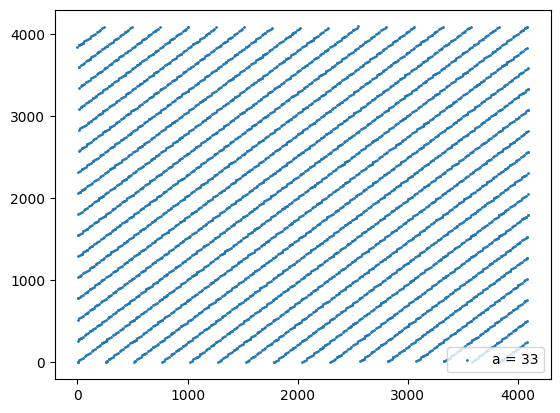

In [9]:
# Generate pairs of random numbers and plot them
lcg = LCG(seed = 0, a = 33, c = 1, m = 2**12)

n = 5000
x = lcg.randint(n)
y = lcg.randint(n)

# plot the tuples (x, y)
plt.figure()
plt.scatter(x, y, s=1)
plt.legend(['a = ' + str(lcg.a)])
plt.show()

The current example with $a = 33$ shows how the pseudorandom numbers follow a specific pattern and do not spread out completely to occupy the entire $\mathbb{R}^2$ vector space. This is quite far from a uniform distribution and is not a good approximation of randomness.

After experimenting with different values of $a$, I observed that prime numbers (e.g. 101) are the best. This makes sense intuitively, since fewer factors of $a$ means fewer ways to approach the same number by linear operations. Odd composite numbers (e.g. 33) are somewhat uniformly distributed, while even numbers repeat only a select few values and make a bad PRNG.

## Final Remarks

Linear Congruential Generators pass many simple statistical tests when used with moderately small sample sizes. As you saw above some bits of an LCG output are more random than others. It is common practice to only use some of the output bits and discard the rest.

However, LCGs are extremely bad for generating random vectors in even 2 dimensions or for large sample sizes in 1 dimension and hence are not recommended for running simulations.

In [10]:
# Written homework question 1, part b
import scipy.stats
chi2_crit = scipy.stats.chi2.ppf(0.95, df=1)
print(chi2_crit)

3.8414588206941205
